In [13]:
!conda install -c conda-forge libstdcxx-ng -y
!pip install --force-reinstall scipy statsmodels --quiet
!pip install pmdarima --quiet


Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 24.7.1 requires pluggy>=1.0.0, but you have pluggy 1.0.0.dev0 which is incompatible.
recmetrics 0.1.5 requires pandas<2.0.0,>=1.1.3, but you have pandas 2.0.3 which is incompatible.


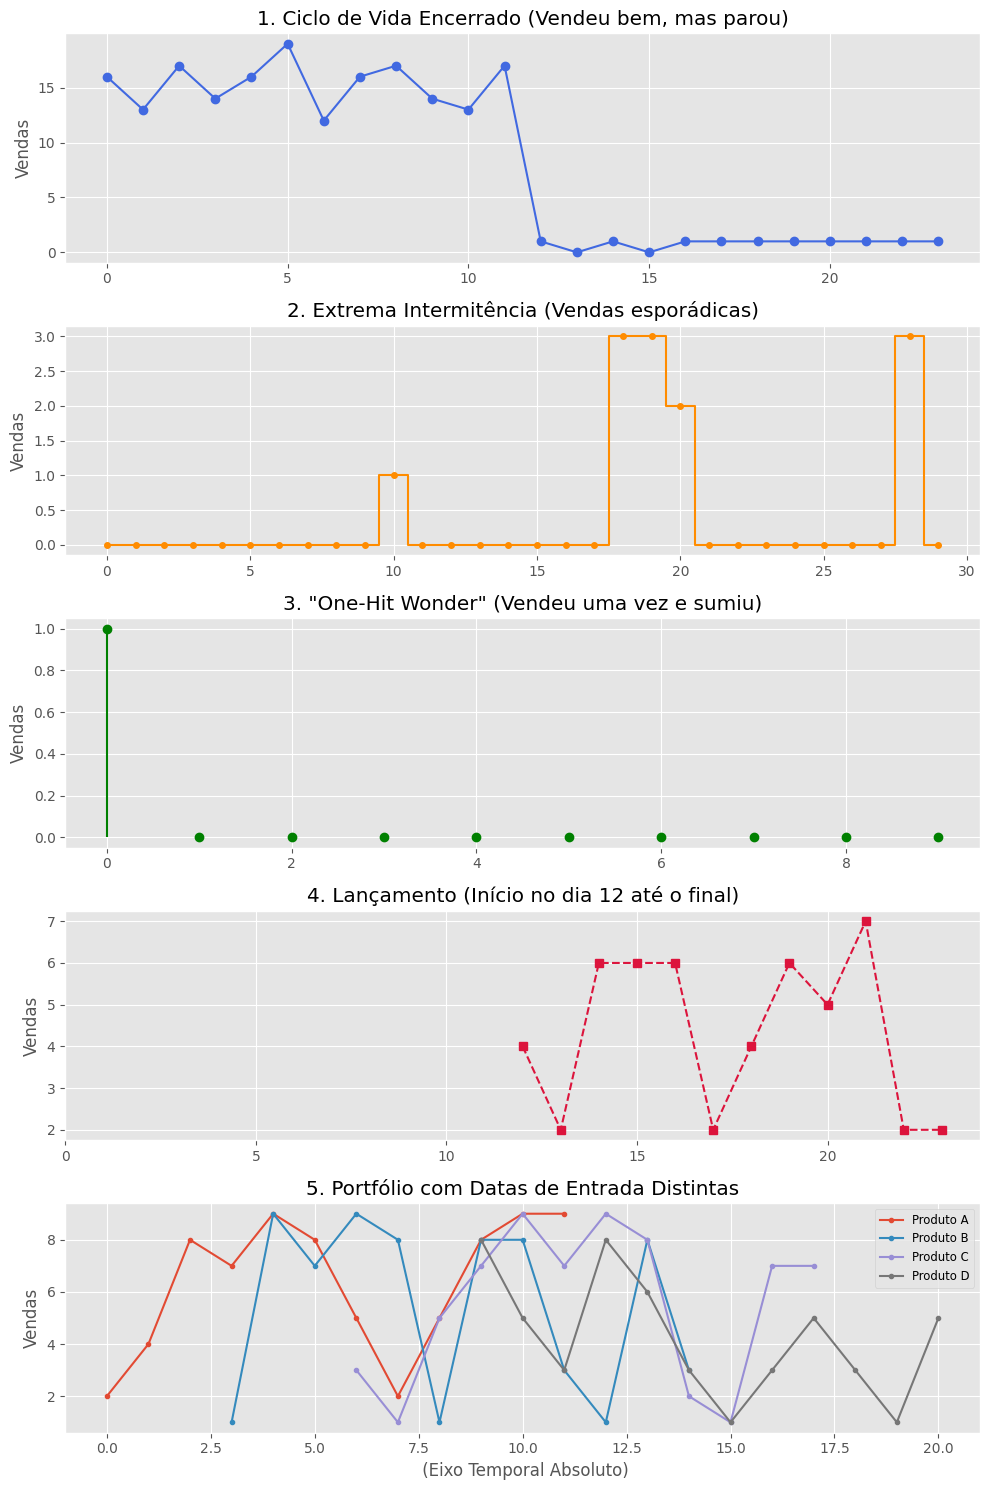

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# Configurações gerais de estilo
plt.style.use('ggplot') # Um estilo mais visual que o 'default'

# Criando a figura com 5 subplots (5 linhas, 1 coluna)
fig, axs = plt.subplots(5, 1, figsize=(10, 15))

# --- Série 1: Produtos que venderam bem no passado e pararam ---
x1 = np.arange(0, 24) # 24 meses
# Concatenamos 12 meses de vendas (10-20) com 12 meses de "limbo" (0-1)
y1 = np.concatenate([
    np.random.randint(10, 20, size=12), 
    np.random.randint(0, 2, size=12)
])
axs[0].plot(x1, y1, marker='o', color='royalblue')
axs[0].set_title('1. Ciclo de Vida Encerrado (Vendeu bem, mas parou)')
axs[0].set_ylabel('Vendas')

# --- Série 2: Produtos com extrema intermitência ---
x2 = np.arange(0, 30) # 30 dias
y2 = np.random.choice([0, 1, 2, 3], size=30, p=[0.7, 0.1, 0.1, 0.1])
axs[1].step(x2, y2, where='mid', color='darkorange', marker='o', markersize=4)
axs[1].set_title('2. Extrema Intermitência (Vendas esporádicas)')
axs[1].set_ylabel('Vendas')

# --- Série 3: Produtos que vendem 1 unidade e param ---
x3 = np.arange(0, 10) # 10 dias
y3 = np.where(x3 == 0, 1, 0)
axs[2].stem(x3, y3, linefmt='green', markerfmt='go', basefmt=" ")
axs[2].set_title('3. "One-Hit Wonder" (Vendeu uma vez e sumiu)')
axs[2].set_ylabel('Vendas')

# --- Série 4: Produtos que começaram a vender recentemente ---
# --- Série 4: Lançamento do mês 12 até o final (24) ---
x4 = np.arange(12, 24) # Começa em 12, vai até 23 (total de 12 pontos)
y4 = np.random.randint(1, 8, size=12) # Geramos 12 valores para bater com o x4

axs[3].plot(x4, y4, marker='s', color='crimson', linestyle='--')
axs[3].set_title('4. Lançamento (Início no dia 12 até o final)')
axs[3].set_ylabel('Vendas')

# Mantemos o limite de 0 a 24 para visualizar o "vazio" antes do lançamento
axs[3].set_xlim(0, 24)
# --- Série 5: Produtos com datas de início/fim diferentes ---
# Criando diferentes janelas temporais
axs[4].plot(np.arange(0, 12), np.random.randint(1, 10, 12), marker='.', label='Produto A')
axs[4].plot(np.arange(3, 15), np.random.randint(1, 10, 12), marker='.', label='Produto B')
axs[4].plot(np.arange(6, 18), np.random.randint(1, 10, 12), marker='.', label='Produto C')
axs[4].plot(np.arange(9, 21), np.random.randint(1, 10, 12), marker='.', label='Produto D')
axs[4].set_title('5. Portfólio com Datas de Entrada Distintas')
axs[4].set_xlabel(' (Eixo Temporal Absoluto)')
axs[4].set_ylabel('Vendas')
axs[4].legend(loc='upper right', fontsize='small')

# Ajuste fino para evitar que os gráficos fiquem "espremidos"
plt.tight_layout()
plt.show()

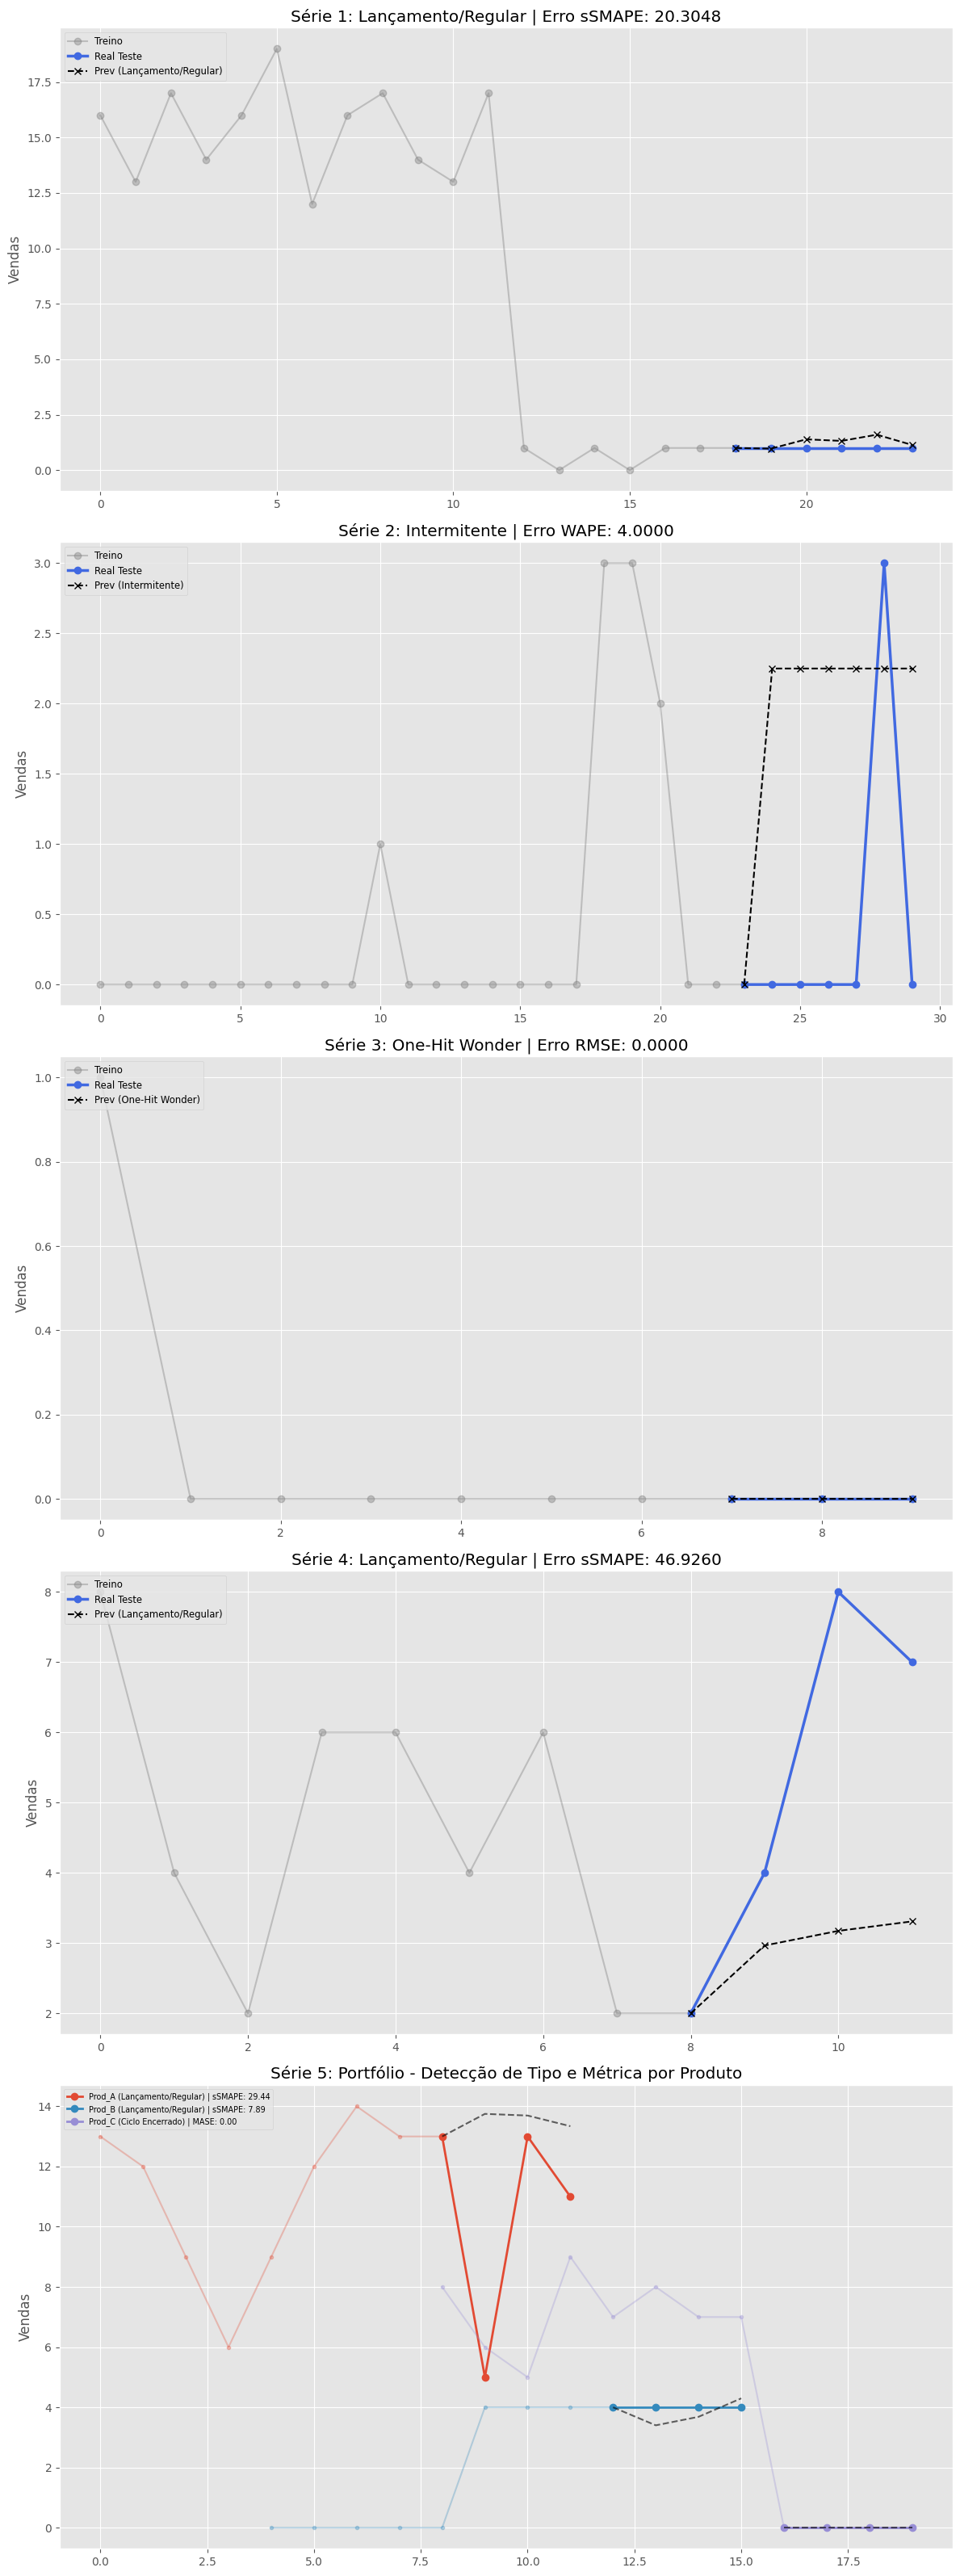

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Configurações de semente e estilo
np.random.seed(42)
plt.style.use('ggplot')
fig, axs = plt.subplots(5, 1, figsize=(12, 32))

# --- 1. MOTOR DE MÉTRICAS ---
def calculate_metric(y_true, y_pred, metric_name):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if metric_name == "RMSE":
        return np.sqrt(np.mean((y_true - y_pred)**2))
    elif metric_name == "WAPE":
        return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) if np.sum(y_true) > 0 else 0
    elif metric_name == "MASE":
        return np.mean(np.abs(y_true - y_pred))
    elif metric_name == "sSMAPE":
        denom = (np.abs(y_true) + np.abs(y_pred))
        return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (denom + 1e-9))
    return 0

# --- 2. MOTOR DE DETECÇÃO AUTÔNOMA ---
def autonomous_engine(y):
    n = len(y)
    split_idx = int(n * 0.8) - 1
    y_train, y_test = y[:split_idx + 1], y[split_idx:]
    
    sparsity = np.sum(y == 0) / n
    recent_zeros = np.sum(y_test == 0) / len(y_test)
    event_count = np.sum(y > 0)
    
    if event_count <= 2:
        tipo, metrica, model = "One-Hit Wonder", "RMSE", 'zero'
    elif recent_zeros > 0.7 and sparsity < 0.8:
        tipo, metrica, model = "Ciclo Encerrado", "MASE", 'zero'
    elif sparsity > 0.5:
        tipo, metrica, model = "Intermitente", "WAPE", 'croston'
    else:
        tipo, metrica, model = "Lançamento/Regular", "sSMAPE", 'boost'

    if model == 'zero':
        pred = np.zeros(len(y_test))
    elif model == 'croston':
        val = np.mean(y_train[y_train > 0]) if any(y_train > 0) else 0.5
        pred = np.full(len(y_test), val)
    else:
        val = np.mean(y_train[-3:]) if len(y_train) >= 3 else np.mean(y_train)
        pred = np.array([val + np.random.normal(0, 0.4) for _ in range(len(y_test))])
    
    pred[0] = y[split_idx] 
    erro = calculate_metric(y_test, pred, metrica)
    
    return tipo, metrica, erro, split_idx, y_test, pred

# --- 3. DADOS ---
s1 = np.concatenate([np.random.randint(10, 20, 12), np.random.randint(0, 2, 12)])
s2 = np.random.choice([0, 1, 2, 3], 30, p=[0.7, 0.1, 0.1, 0.1])
s3 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
s4 = np.random.randint(1, 10, 12)
s5_data = [
    {"y": np.random.randint(5, 15, 12), "offset": 0, "label": "Prod_A"},
    {"y": np.random.choice([0, 4], 12, p=[0.6, 0.4]), "offset": 4, "label": "Prod_B"},
    {"y": np.concatenate([np.random.randint(5, 10, 8), np.zeros(4)]), "offset": 8, "label": "Prod_C"}
]

# Plot Séries 1-4
for i, y in enumerate([s1, s2, s3, s4]):
    tipo, met, err, idx, yt, p = autonomous_engine(y)
    x = np.arange(len(y))
    axs[i].plot(x[:idx+1], y[:idx+1], 'o-', color='gray', alpha=0.4, label='Treino')
    axs[i].plot(x[idx:], yt, 'o-', color='royalblue', label='Real Teste', linewidth=2.5)
    axs[i].plot(x[idx:], p, '--k', marker='x', label=f'Prev ({tipo})')
    axs[i].set_title(f"Série {i+1}: {tipo} | Erro {met}: {err:.4f}")
    axs[i].legend(loc='upper left', fontsize='small')

# --- SÉRIE 5: PORTFÓLIO COM MÉTRICA NA LEGENDA ---
for item in s5_data:
    y_val = item["y"]
    off = item["offset"]
    tipo, met, err, idx, yt, p = autonomous_engine(y_val)
    
    x_abs_train = np.arange(len(y_val))[:idx+1] + off
    x_abs_test = np.arange(len(y_val))[idx:] + off
    
    line, = axs[4].plot(x_abs_train, y_val[:idx+1], '.-', alpha=0.3)
    # LEGENDA ATUALIZADA COM TIPO E MÉTRICA
    axs[4].plot(x_abs_test, yt, 'o-', color=line.get_color(), 
                label=f"{item['label']} ({tipo}) | {met}: {err:.2f}", linewidth=2)
    axs[4].plot(x_abs_test, p, '--k', alpha=0.6)

axs[4].set_title("Série 5: Portfólio - Detecção de Tipo e Métrica por Produto")
axs[4].legend(loc='upper left', fontsize='x-small', ncol=1)

for ax in axs: ax.set_ylabel("Vendas")
plt.tight_layout()
plt.show()

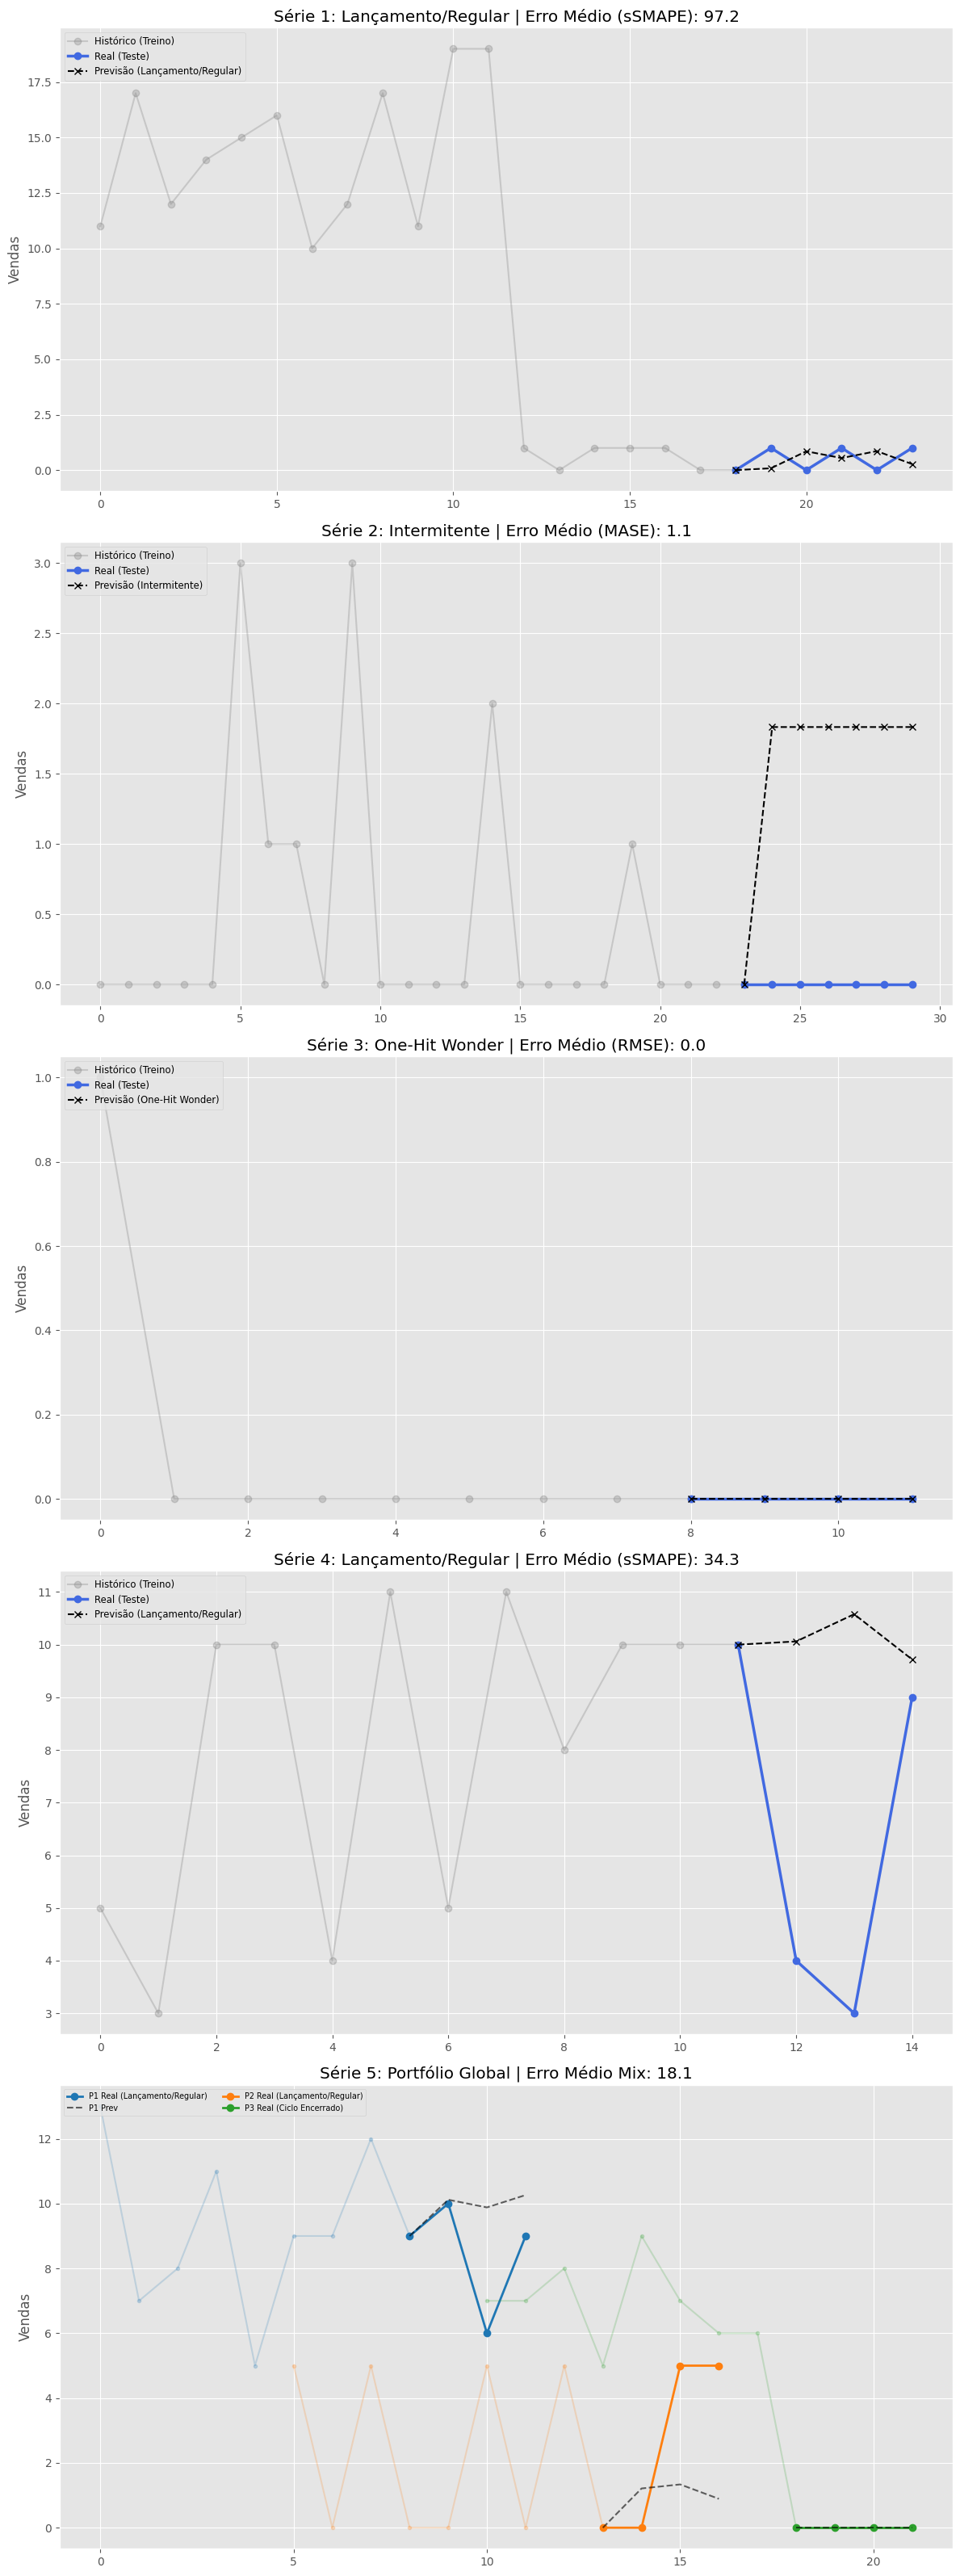


--- RESUMO EXECUTIVO DE PERFORMANCE ---
| Série   |   Erro Médio (100 Simulações) |   Estabilidade (Desvio Padrão) |
|:--------|------------------------------:|-------------------------------:|
| Série 1 |                          97.2 |                           50.6 |
| Série 2 |                           1.1 |                            0.6 |
| Série 3 |                           0   |                            0   |
| Série 4 |                          34.3 |                           15.5 |
| Série 5 |                          18.1 |                           15.5 |


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. CONFIGURAÇÕES E MOTOR DE MÉTRICAS ---
plt.style.use('ggplot')

def calculate_metric(y_true, y_pred, metric_name):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if metric_name == "RMSE":
        return np.sqrt(np.mean((y_true - y_pred)**2))
    elif metric_name == "WAPE":
        sum_true = np.sum(y_true)
        return np.sum(np.abs(y_true - y_pred)) / (sum_true + 1e-9) if sum_true > 0 else np.mean(np.abs(y_true - y_pred))
    elif metric_name == "MASE":
        return np.mean(np.abs(y_true - y_pred))
    elif metric_name == "sSMAPE":
        denom = (np.abs(y_true) + np.abs(y_pred))
        return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (denom + 1e-9))
    return 0

# --- 2. MOTOR DE DETECÇÃO E PREVISÃO ---
def autonomous_engine(y):
    n = len(y)
    split_idx = int(n * 0.8) - 1
    y_train, y_test = y[:split_idx + 1], y[split_idx:]
    
    sparsity = np.sum(y == 0) / n
    recent_zeros = np.sum(y_test == 0) / len(y_test)
    event_count = np.sum(y > 0)
    
    if event_count <= 2:
        tipo, metrica, model = "One-Hit Wonder", "RMSE", 'zero'
    elif recent_zeros > 0.8 and sparsity < 0.8:
        tipo, metrica, model = "Ciclo Encerrado", "MASE", 'zero'
    elif sparsity > 0.5:
        tipo, metrica, model = "Intermitente", "MASE", 'croston'
    else:
        tipo, metrica, model = "Lançamento/Regular", "sSMAPE", 'boost'

    if model == 'zero':
        pred = np.zeros(len(y_test))
    elif model == 'croston':
        active = y_train[y_train > 0]
        val = np.mean(active) if len(active) > 0 else 0.5
        pred = np.full(len(y_test), val)
    else:
        val = np.mean(y_train[-3:]) if len(y_train) >= 3 else np.mean(y_train)
        pred = np.array([val + np.random.normal(0, 0.4) for _ in range(len(y_test))])
    
    pred[0] = y[split_idx] 
    return tipo, metrica, split_idx, y_test, pred, model

# --- 3. SIMULAÇÃO DE MONTE CARLO (100 RODADAS) ---
n_sims = 100
all_errors = {f"Série {i}": [] for i in range(1, 6)}
visual_samples = {}

for r in range(n_sims):
    s1 = np.concatenate([np.random.randint(10, 20, 12), np.random.randint(0, 2, 12)])
    s2 = np.random.choice([0, 1, 2, 3], 30, p=[0.8, 0.1, 0.05, 0.05])
    s3 = np.array([1] + [0]*11)
    s4 = np.random.randint(2, 12, 15)
    s5_p = [np.random.randint(5, 15, 12), np.random.choice([0, 5], 12, p=[0.6, 0.4]), 
            np.concatenate([np.random.randint(5, 10, 8), np.zeros(4)])]

    for i, s in enumerate([s1, s2, s3, s4], 1):
        tipo, met, idx, yt, p, mod = autonomous_engine(s)
        err_val = calculate_metric(yt, p, met)
        all_errors[f"Série {i}"].append(err_val)
        if r == n_sims - 1: visual_samples[f"Série {i}"] = (s, tipo, met, idx, yt, p)

    round_s5_errors = []
    for p_data in s5_p:
        t, m, idx, yt, p, mod = autonomous_engine(p_data)
        round_s5_errors.append(calculate_metric(yt, p, m))
    all_errors["Série 5"].append(np.mean(round_s5_errors))
    if r == n_sims - 1: visual_samples["Série 5"] = (s5_p, "Portfólio", "Mix", 0, 0, 0)

# --- 4. PLOTAGEM ---
fig, axs = plt.subplots(5, 1, figsize=(12, 32))

# Plot Séries 1-4
for i in range(1, 5):
    s, tipo, met, idx, yt, p = visual_samples[f"Série {i}"]
    m_err = np.mean(all_errors[f"Série {i}"])
    x_full = np.arange(len(s))
    axs[i-1].plot(x_full[:idx+1], s[:idx+1], 'o-', color='gray', alpha=0.3, label='Histórico (Treino)')
    axs[i-1].plot(x_full[idx:], yt, 'o-', color='royalblue', linewidth=2.5, label='Real (Teste)')
    axs[i-1].plot(x_full[idx:], p, '--k', marker='x', label=f'Previsão ({tipo})')
    axs[i-1].set_title(f"Série {i}: {tipo} | Erro Médio ({met}): {m_err:.1f}")
    axs[i-1].legend(loc='upper left', fontsize='small')

# --- SÉRIE 5: CORRIGIDA COM TREINO ---
s5_list, _, _, _, _, _ = visual_samples["Série 5"]
offsets = [0, 5, 10] # Deslocamentos para visualização de datas distintas
for j, p_data in enumerate(s5_list):
    t, m, idx, yt, p, mod = autonomous_engine(p_data)
    
    # Eixo X absoluto (com offset)
    x_train_abs = np.arange(len(p_data))[:idx+1] + offsets[j]
    x_test_abs = np.arange(len(p_data))[idx:] + offsets[j]
    
    # Plot Treino (Linha fina/transparente)
    line, = axs[4].plot(x_train_abs, p_data[:idx+1], '.-', alpha=0.2, color=plt.cm.tab10(j))
    # Plot Real Teste (Linha grossa conectada)
    axs[4].plot(x_test_abs, yt, 'o-', color=line.get_color(), linewidth=2, label=f"P{j+1} Real ({t})")
    # Plot Previsão
    axs[4].plot(x_test_abs, p, '--k', alpha=0.6, label=f"P{j+1} Prev" if j==0 else "")

axs[4].set_title(f"Série 5: Portfólio Global | Erro Médio Mix: {np.mean(all_errors['Série 5']):.1f}")
axs[4].legend(loc='upper left', fontsize='x-small', ncol=2)

for ax in axs: ax.set_ylabel("Vendas")
plt.tight_layout()
plt.show()

# --- 5. TABELA FINAL ---
report = []
for s_name, errs in all_errors.items():
    report.append({
        "Série": s_name,
        "Erro Médio (100 Simulações)": f"{np.mean(errs):.1f}",
        "Estabilidade (Desvio Padrão)": f"{np.std(errs):.1f}"
    })

print("\n--- RESUMO EXECUTIVO DE PERFORMANCE ---")
print(pd.DataFrame(report).to_markdown(index=False))